In [78]:
import numpy as np
import re
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

#teste = '/Volumes/GoogleDrive/My Drive/Estudos/IC/Henrique/Programs/Pre-processing/teste.txt'
#arquivo2 = '/Volumes/GoogleDrive/My Drive/Estudos/IC/Henrique/Programs/Pre-processing/RM1171200.111'
# arquivo2 = '/Volumes/GoogleDrive/My Drive/Estudos/IC/Henrique/Programs/Pre-processing/RM1171200 copy.111'

arquivo = '/Volumes/GoogleDrive/My Drive/Estudos/IC/Henrique/Programs/RMlicelPython/RM1120200.012'

Links úteis:

[1] https://stackoverflow.com/questions/628556/returning-only-part-of-match-from-regular-expression

[2] https://stackoverflow.com/questions/8006551/how-to-split-long-regular-expression-rules-to-multiple-lines-in-python

[3] https://stackoverflow.com/questions/1327369/extract-part-of-a-regex-match

[4] https://stackoverflow.com/a/54692662

[5] https://stackoverflow.com/questions/5832856/how-to-read-file-n-lines-at-a-time

[6] https://numpy.org/doc/stable/user/basics.types.html?highlight=array  (data types do Python)

In [79]:
def profile_read(fname, dbin=0, dtime=0, ach=0, maxz=0):
    
    head = {}
    
    # Abrindo o arquivo
    
    with open(fname, 'r', encoding='utf8', errors='ignore') as fp:
        
        ## Linha 1
        regexp = re.compile('([\w]{9}.[\d]{3})')             # filename
        
        line = regexp.search(fp.readline())
        
        head['file'] = line.group(1)
        
        ## Linha 2
        regexp = re.compile(' ([\w_ ]*) '                    # site
                             '([\d]{2}/[\d]{2}/[\d]{4}) '    # datei
                             '([\d]{2}:[\d]{2}:[\d]{2}) '    # houri
                             '([\d]{2}/[\d]{2}/[\d]{4}) '    # datef
                             '([\d]{2}:[\d]{2}:[\d]{2}) '    # hourf
                             '([\d]{4}) '                    # alt
                             '(-?[\d]{3}\.\d) '              # lon
                             '(-?[\d]{3}\.\d) '              # lat
                             '(-?[\d]{2}) '                  # zen
                             '[\d]{2} '                      # ---- empty
                             '([\d]{2}\.\d) '                # T0
                             '([\d]{4}\.\d)')                # P0 
        
        line = regexp.search(fp.readline())
    
        head['site']  = line.group(1)
        head['datei'] = line.group(2)
        head['houri'] = line.group(3)
        head['datef'] = line.group(4)
        head['hourf'] = line.group(5)
        
        def datenum(d):    # Conversão da datenum do matlab pra python (Link [4])
            return 366 + d.toordinal() + (d - datetime.fromordinal(d.toordinal())).total_seconds()/(24*60*60)

        jdi = head['datei'] + ' ' + head['houri']
        jdi_strip = datetime.strptime(jdi, '%d/%m/%Y %H:%M:%S')
        
        jdf = head['datef'] + ' ' + head['hourf']
        jdf_strip = datetime.strptime(jdf, '%d/%m/%Y %H:%M:%S')
        
        head['jdi'] = datenum(jdi_strip)
        head['jdf'] = datenum(jdf_strip)
        
        head['alt'] = int(line.group(6))
        head['lon'] = float(line.group(7))
        head['lat'] = float(line.group(8))
        head['zen'] = float(line.group(9))
        head['T0']  = float(line.group(10)) 
        head['P0']  = float(line.group(11))
        
        ## Linha 3
        regexp = re.compile('([\d]{7}) '      # nshoots    
                            '([\d]{4}) '      # nhz
                            '([\d]{7}) '      # nshoots2
                            '([\d]{4}) '      # nhz2
                            '([\d]{2}) ')     # nch
        
        line = regexp.search(fp.readline())
        
        head['nshoots']  = int(line.group(1))
        head['nhz']      = int(line.group(2))
        head['nshoots2'] = int(line.group(3))
        head['nhz2']     = int(line.group(4))
        head['nch']      = int(line.group(5))
        
        ## Canais
        
        head['ch'] = {}
        nch = head['nch']            # Número de canais
        
        regexp = re.compile('(\d) '                # active
                            '(\d) '                # photons
                            '(\d) '                # elastic
                            '([\d]{5}) '           # ndata
                            '\d '                  # ----
                            '([\d]{4}) '           # pmtv
                            '(\d\.[\d]{2}) '       # binw
                            '([\d]{5})\.'          # wlen
                            '([osl]) '             # pol
                            '[0 ]{10} '            # ----
                            '([\d]{2}) '           # bits
                            '([\d]{6}) '           # nshoots
                            '(\d\.[\d]{3,4}) '     # discr
                            '([\w]{3})')           # tr

                            
        channels = ''.join([next(fp) for x in range(nch)])  # Aqui eu imprimo todos os canais
                                                            
        lines = np.array(regexp.findall(channels))
        
        head['ch']['active']  = lines[:, 0].astype(int)
        head['ch']['photons'] = lines[:, 1].astype(int)
        head['ch']['elastic'] = lines[:, 2].astype(int)
        head['ch']['ndata']   = lines[:, 3].astype(int)
        head['ch']['pmtv']    = lines[:, 4].astype(int)
        head['ch']['binw']    = lines[:, 5].astype(float)
        head['ch']['wlen']    = lines[:, 6].astype(int)
        head['ch']['pol']     = lines[:, 7]
        head['ch']['bits']    = lines[:, 8].astype(int)
        head['ch']['nshoots'] = lines[:, 9].astype(int)
        head['ch']['discr']   = lines[:, 10].astype(float)
        head['ch']['tr']      = lines[:, 11]
        
        # Criei os arrays phy e raw antes, pois no matlab elas são criadas enquanto declaradas
        
        max_linhas = max(head['ch']['ndata'])       # A solucao que encontrei aqui foi achar o max de
                                                    # linhas possivel que phy e raw podem ter para declarar antes        
        
        if ach == 0:
            phy = np.zeros((max_linhas, nch))
            raw = np.zeros((max_linhas, nch))
        else:
            phy = np.zeros((max_linhas, 1))
            raw = np.zeros((max_linhas, 1))            
 
        # conversion factor from raw to physical units
        for ch in range(nch):
            nz = head['ch']['ndata'][ch]
            trash=np.fromfile(fp, np.byte, 2)
            tmpraw = np.fromfile(fp, np.int32, nz)
            if ch == ach or ach == 0:
                if head['ch']['photons'][ch] == 0:
                    dScale = head['ch']['nshoots'][ch]*(2**head['ch']['bits'][ch])/(head['ch']['discr'][ch]*1e3)
                else:
                    dScale = head['ch']['nshoots'][ch]/20.
            
            tmpphy=tmpraw/dScale
            
            if ch == 1 or ch == 3:
                # displace by dbin's
                tmpphy[:nz-dbin] = tmpphy[dbin:nz]
                
                # repeat the last dbin values to keep size of vectors
                tmpphy[nz-dbin:nz] = tmpphy[nz-dbin:nz]
            else:
                # correct for dead-time
                tmpphy[:nz] = tmpphy[:nz]/(1-tmpphy[:nz]*dtime)
            
            # copy to final destination
            
            if maxz == 0:
                maxz = nz
            else:
                maxz = min(nz, maxz)
                head['ch']['ndata'][ch] = maxz
            
            if ach == 0:
                phy[:maxz, ch] = tmpphy[:maxz]
                raw[:maxz, ch] = tmpraw[:maxz]
            else:
                phy[:maxz] = tmpphy[:maxz]
                raw[:maxz] = tmpraw[:maxz]    
        
        
    return head, phy, raw

In [80]:
read = profile_read(arquivo)
read

({'file': 'RM1120200.012',
  'site': 'Embrapa_',
  'datei': '02/02/2011',
  'houri': '00:00:28',
  'datef': '02/02/2011',
  'hourf': '00:01:29',
  'jdi': 734536.0003240741,
  'jdf': 734536.0010300926,
  'alt': 100,
  'lon': -60.0,
  'lat': -2.9,
  'zen': -90.0,
  'T0': 30.0,
  'P0': 1013.0,
  'nshoots': 600,
  'nhz': 10,
  'nshoots2': 600,
  'nhz2': 10,
  'nch': 5,
  'ch': {'active': array([1, 1, 1, 1, 1]),
   'photons': array([0, 1, 0, 1, 1]),
   'elastic': array([1, 1, 2, 2, 2]),
   'ndata': array([4000, 4000, 4000, 4000, 4000]),
   'pmtv': array([960, 960, 990, 990, 990]),
   'binw': array([7.5, 7.5, 7.5, 7.5, 7.5]),
   'wlen': array([355, 355, 387, 387, 408]),
   'pol': array(['o', 'o', 'o', 'o', 'o'], dtype='<U6'),
   'bits': array([12,  0, 12,  0,  0]),
   'nshoots': array([600, 600, 600, 600, 600]),
   'discr': array([0.5   , 3.1746, 0.02  , 3.1746, 3.1746]),
   'tr': array(['BT0', 'BC0', 'BT1', 'BC1', 'BC2'], dtype='<U6')}},
 array([[  1.61763509, 146.93333333,   1.99802246, 11

In [81]:
phy = read[1]
np.savetxt('RM1120200.012.txt', phy)

In [82]:
df = pd.DataFrame(phy)

# Aqui é um jeito provisório de fazer o header

lista = []
for i in range(len(read[0]['ch']['active'])):
    wlen = str(read[0]['ch']['wlen'][i])
    pol = str(read[0]['ch']['pol'][i])
    photon = read[0]['ch']['photons'][i]
    an = 'analog' if photon == 0 else 'photon'
    tr = read[0]['ch']['tr'][i]
    lista.append(wlen + ' ' + pol + ' ' + an + ' ' + tr[-1])

###############################################


df.columns = lista

In [83]:
df

,355 o analog 0,355 o photon 0,387 o analog 1,387 o photon 1,408 o photon 2
0,1.617635,146.933333,1.998022,114.600000,5.133333
1,1.610718,141.533333,1.998438,97.100000,3.400000
2,1.619263,138.633333,1.997949,84.433333,2.400000
3,1.616618,140.833333,1.997770,76.933333,2.633333
4,1.616618,138.033333,1.998617,77.700000,2.600000
...,...,...,...,...,...
3995,1.630249,0.000000,2.000342,0.000000,0.000000
3996,1.627401,0.000000,2.001286,0.000000,0.000000
3997,1.628825,0.000000,2.001766,0.000000,0.000000
3998,1.634521,0.000000,2.001449,0.000000,0.000000


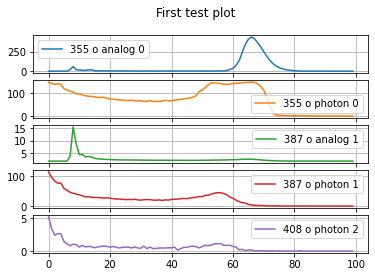

In [94]:
plot = df[:100].plot(grid=True, subplots=True, title='First test plot')